# 10x RNA-seq gene expression data (part 2b)

We can continue to explore our examples looking at the expression of canonical neurotransmitter transporter genes and gene Tac2 over the whole brain. 

You need to be connected to the internet to run this notebook and that you have downloaded the example data via the getting started notebook.

In [1]:
import os
import pandas as pd
import numpy as np
import anndata
import time
import json
import matplotlib.pyplot as plt
import requests
import seaborn as sns
import matplotlib.patches as mpatches
from tqdm.notebook import tqdm

The prerequisite for running this notebook is that the data have been downloaded to local directory maintaining the organization from the manifest.json. **Change the download_base variable to where you have downloaded the data in your system.**

In [2]:
version = '20230830'
download_base =  '/alzheimer/Roberto/Allen_Institute/abc_download_root'

use_local_cache = False
manifest_path = 'releases/%s/manifest.json' % version

if not use_local_cache :
    url = 'https://allen-brain-cell-atlas.s3-us-west-2.amazonaws.com/' + manifest_path
    manifest = json.loads(requests.get(url).text)
else :
    file = os.path.join(download_base,manifest_path)
    with open(file,'rb') as f:
        manifest = json.load(f)
    
metadata = manifest['file_listing']['WMB-10X']['metadata']

In [3]:
view_directory = os.path.join( download_base, 
                               manifest['directory_listing']['WMB-10X']['directories']['metadata']['relative_path'], 
                              'views')
cache_views = False
if cache_views :
    os.makedirs( view_directory, exist_ok=True )

Read in the expanded cell metadata table we created in part 1.

In [4]:
rpath = metadata['cell_metadata_with_cluster_annotation']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath )
cell = pd.read_csv(file, keep_default_na=False)
cell.set_index('cell_label',inplace=True)

In [6]:
matrices = cell.groupby(['dataset_label','feature_matrix_label'])[['library_label']].count()
matrices.columns  = ['cell_count']


In [7]:
rpath = metadata['example_genes_all_cells_expression']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
exp = pd.read_csv(file)
exp.set_index('cell_label',inplace=True)
exp  = exp.sort_index(axis=1)


# Expression of Htr in the whole brain

In [51]:
exp.columns

Index(['Htr1a', 'Htr1b', 'Htr1d', 'Htr1f', 'Htr2a', 'Htr2b', 'Htr2c', 'Htr3a',
       'Htr3b', 'Htr4', 'Htr5a', 'Htr5b', 'Htr6', 'Htr7'],
      dtype='object')

In [17]:
class_to_division={'01 IT-ET Glut': "Isocortex Glut",
'02 NP-CT-L6b Glut': "Isocortex Glut",
'03 OB-CR Glut':"Olfactory Glut",
'04 DG-IMN Glut':"Isocortex Glut",
'05 OB-IMN GABA':"Olfactory Glut", 
'06 CTX-CGE GABA': "Isocortex Gaba",
'07 CTX-MGE GABA': "Isocortex Gaba", 
'08 CNU-MGE GABA': "CNU Gaba", 
'09 CNU-LGE GABA': "CNU Gaba", 
'10 LSX GABA': "CNU Gaba",  
'11 CNU-HYa GABA': "CNU-HY Gaba",  
'12 HY GABA': "HY Glut",  
'13 CNU-HYa Glut': "HY Glut",
'14 HY Glut': "HY Glut", 
'15 HY Gnrh1 Glut': "HY Glut", 
'16 HY MM Glut': "HY Glut",
'17 MH-LH Glut': "TH Glut",
'18 TH Glut': "TH Glut", 
'19 MB Glut': "MB Glut", 
'20 MB GABA': "MB Gaba",
'21 MB Dopa': "MB Dopa",
'22 MB-HB Sero': "MB Sero", 
'23 P Glut': "HB Glut",  
'24 MY Glut': "HB Glut", 
'25 Pineal Glut': "TH Glut", 
'26 P GABA': "HB Gaba", 
'27 MY GABA': "HB Gaba",  
'28 CB GABA': "HB Gaba", 
'29 CB Glut': "HB Glut", 
'30 Astro-Epen': "Non-neuronal", 
'31 OPC-Oligo': "Non-neuronal", 
'32 OEC': "Non-neuronal", 
'33 Vascular': "Non-neuronal", 
'34 Immune': "Non-neuronal"}

In [18]:
cell["division"] = cell['class'].map(class_to_division)

In [19]:
htrgenes = exp.columns

joined = cell.join( exp )
subsampled = joined.loc[::10]

htrgenes = htrgenes.sort_values()

### total expression htr 

In [56]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors

In [58]:
# Family breakdown
families = {
    'Htr1': ['Htr1a', 'Htr1b', 'Htr1d', 'Htr1f'],
    'Htr2': ['Htr2a', 'Htr2b', 'Htr2c'],
    'Htr3': ['Htr3a', 'Htr3b'],
    'Htr4': ['Htr4'],
    'Htr5': ['Htr5a', 'Htr5b'],
    'Htr6': ['Htr6'],
    'Htr7': ['Htr7']
}

base_colors = sns.color_palette("husl", n_colors=len(families))
color_map = {}

for idx, (family, members) in enumerate(families.items()):
    shades = sns.light_palette(base_colors[idx], n_colors=len(members) + 1)[1:]
    for receptor, shade in zip(members, shades):
        color_map[receptor] = shade

# Convert RGB to HEX
htr_cmap = {k: matplotlib.colors.rgb2hex(v) for k, v in color_map.items()}



In [59]:
htr_cmap

{'Htr1a': '#f4d0d6',
 'Htr1b': '#f5b0bc',
 'Htr1d': '#f690a2',
 'Htr1f': '#f77189',
 'Htr2a': '#e4d1af',
 'Htr2b': '#d5b270',
 'Htr2c': '#c69432',
 'Htr3a': '#b7ce8b',
 'Htr3b': '#82a931',
 'Htr4': '#34af8a',
 'Htr5a': '#92ced6',
 'Htr5b': '#37aabb',
 'Htr6': '#8197f4',
 'Htr7': '#f45deb'}

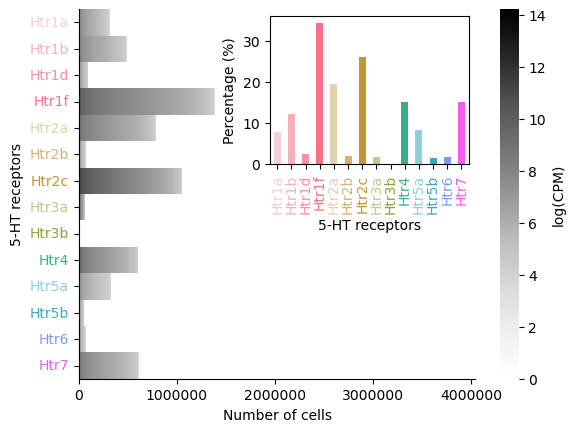

In [71]:
ax = sns.heatmap(pd.DataFrame(np.sort(exp.values, axis=0)[::-200], columns=exp.columns, 
                              index=exp.reset_index().index[::200]).T, xticklabels=5000, cbar_kws={'label': 'log(CPM)'}, cmap="Greys")
ax.set_xlabel("Number of cells")
ax.set_ylabel("5-HT receptors")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

colors_list = [htr_cmap[receptor] for receptor in exp.columns]

for ytick, color in zip(ax.get_yticklabels(), colors_list):
    ytick.set_color(htr_cmap[ytick.get_text()])

axins = inset_axes(ax, width="50%", height="40%", loc=1)
((exp.astype("bool").sum(axis=0)/exp.shape[0])*100).plot.bar(ax=axins, color=colors_list)
axins.set_xlabel("5-HT receptors")
axins.set_ylabel("Percentage (%)")

for xtick, color in zip(axins.get_xticklabels(), colors_list):
    xtick.set_color(htr_cmap[xtick.get_text()])

In [85]:
gene

'Htr7'

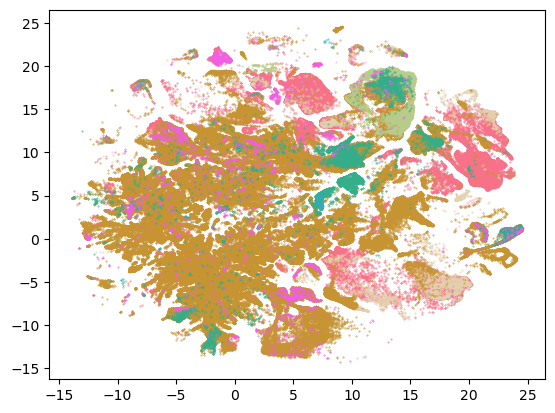

In [93]:

for gene in exp.columns:
    _ = joined[joined[gene]>9]   
    plt.scatter(_['x'], _['y'], c=htr_cmap[gene], s=0.5, marker='.')

### expression htr grouped by neurotransmitter

Text(0.5, 23.52222222222222, '5-HT receptors')

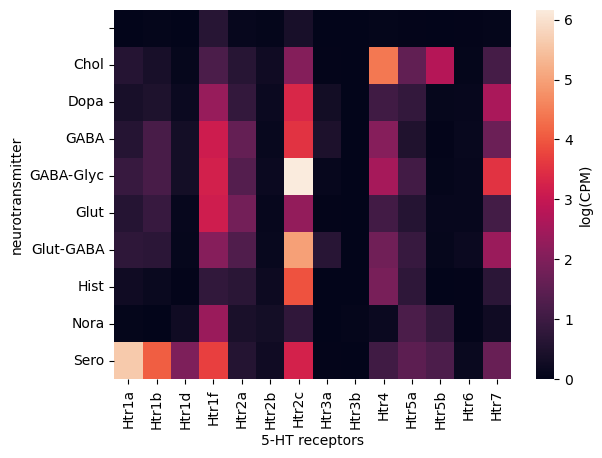

In [74]:
ax = sns.heatmap(joined.groupby("neurotransmitter")[htrgenes].mean(), yticklabels=True, cbar_kws={'label': 'log(CPM)'}, cmap="rocket")
ax.set_xlabel("5-HT receptors")

## UMAP 5-HT receptors vs neurotransmitter, class, region

In [846]:
rpath = metadata['region_of_interest_metadata']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
roi = pd.read_csv(file)
roi.set_index('acronym',inplace=True)
roi.rename(columns={'order':'region_of_interest_order','color_hex_triplet':'region_of_interest_color'},inplace=True)
roi.sort_index()

label  \
acronym                                  
ACA                            WMB-ACA   
AI                              WMB-AI   
AUD                            WMB-AUD   
AUD-TEa-PERI-ECT  WMB-AUD-TEa-PERI-ECT   
CB                              WMB-CB   
CTXsp                        WMB-CTXsp   
ENT                            WMB-ENT   
HIP                            WMB-HIP   
HY                              WMB-HY   
LSX                            WMB-LSX   
MB                              WMB-MB   
MO-FRP                      WMB-MO-FRP   
MOp                            WMB-MOp   
MY                              WMB-MY   
OLF                            WMB-OLF   
P                                WMB-P   
PAL                            WMB-PAL   
PL-ILA-ORB              WMB-PL-ILA-ORB   
RHP                            WMB-RHP   
RSP                            WMB-RSP   
SS-GU-VISC              WMB-SS-GU-VISC   
SSp                            WMB-SSp   
STRd                          WMB-STRd   
STRv                          WMB-STRv   
TEa-PERI-ECT          WMB-TEa-PERI-ECT   
TH                              WMB-TH   
VIS                            WMB-VIS   
VIS-PTLp                  WMB-VIS-PTLp   
sAMY                          WMB-sAMY   

                                                           name  \
acronym                                                           
ACA                                     Anterior cingulate area   
AI                                       Agranular insular area   
AUD                                              Auditory areas   
AUD-TEa-PERI-ECT  Auditory/temporal/perirhinal/ectorhinal areas   
CB                                                   Cerebellum   
CTXsp                                         Cortical subplate   
ENT                                             Entorhinal area   
HIP                                          Hippocampal region   
HY                                                 Hypothalamus   
LSX                                      Lateral septal complex   
MB                                                     Midbrain   
MO-FRP                               Somatomotor - Frontal pole   
MOp                                          Primary motor area   
MY                                                      Medulla   
OLF                                             Olfactory areas   
P                                                          Pons   
PAL                                                    Pallidum   
PL-ILA-ORB                 Prelimbic/infralimbic/orbital areas    
RHP                                     Retrohippocampal region   
RSP                                          Retrosplenial area   
SS-GU-VISC               Somatosensory/gustatory/visceral areas   
SSp                                  Primary somatosensory area   
STRd                                     Striatum dorsal region   
STRv                                    Striatum ventral region   
TEa-PERI-ECT              Temporal/perirhinal/ectorhinal areas    
TH                                                     Thalamus   
VIS                                                Visual areas   
VIS-PTLp                       Visual/posterior parietal  areas   
sAMY                             Striatum-like amygdalar nuclei   

                  region_of_interest_order region_of_interest_color  
acronym                                                              
ACA                                      8                  #00990A  
AI                                      10                  #6F9945  
AUD                                      4                  #455A99  
AUD-TEa-PERI-ECT                         5                  #84FF4D  
CB                                      28                  #CC0026  
CTXsp                                   17                  #994817  
ENT                                     16                  #99922E  
HIP                   

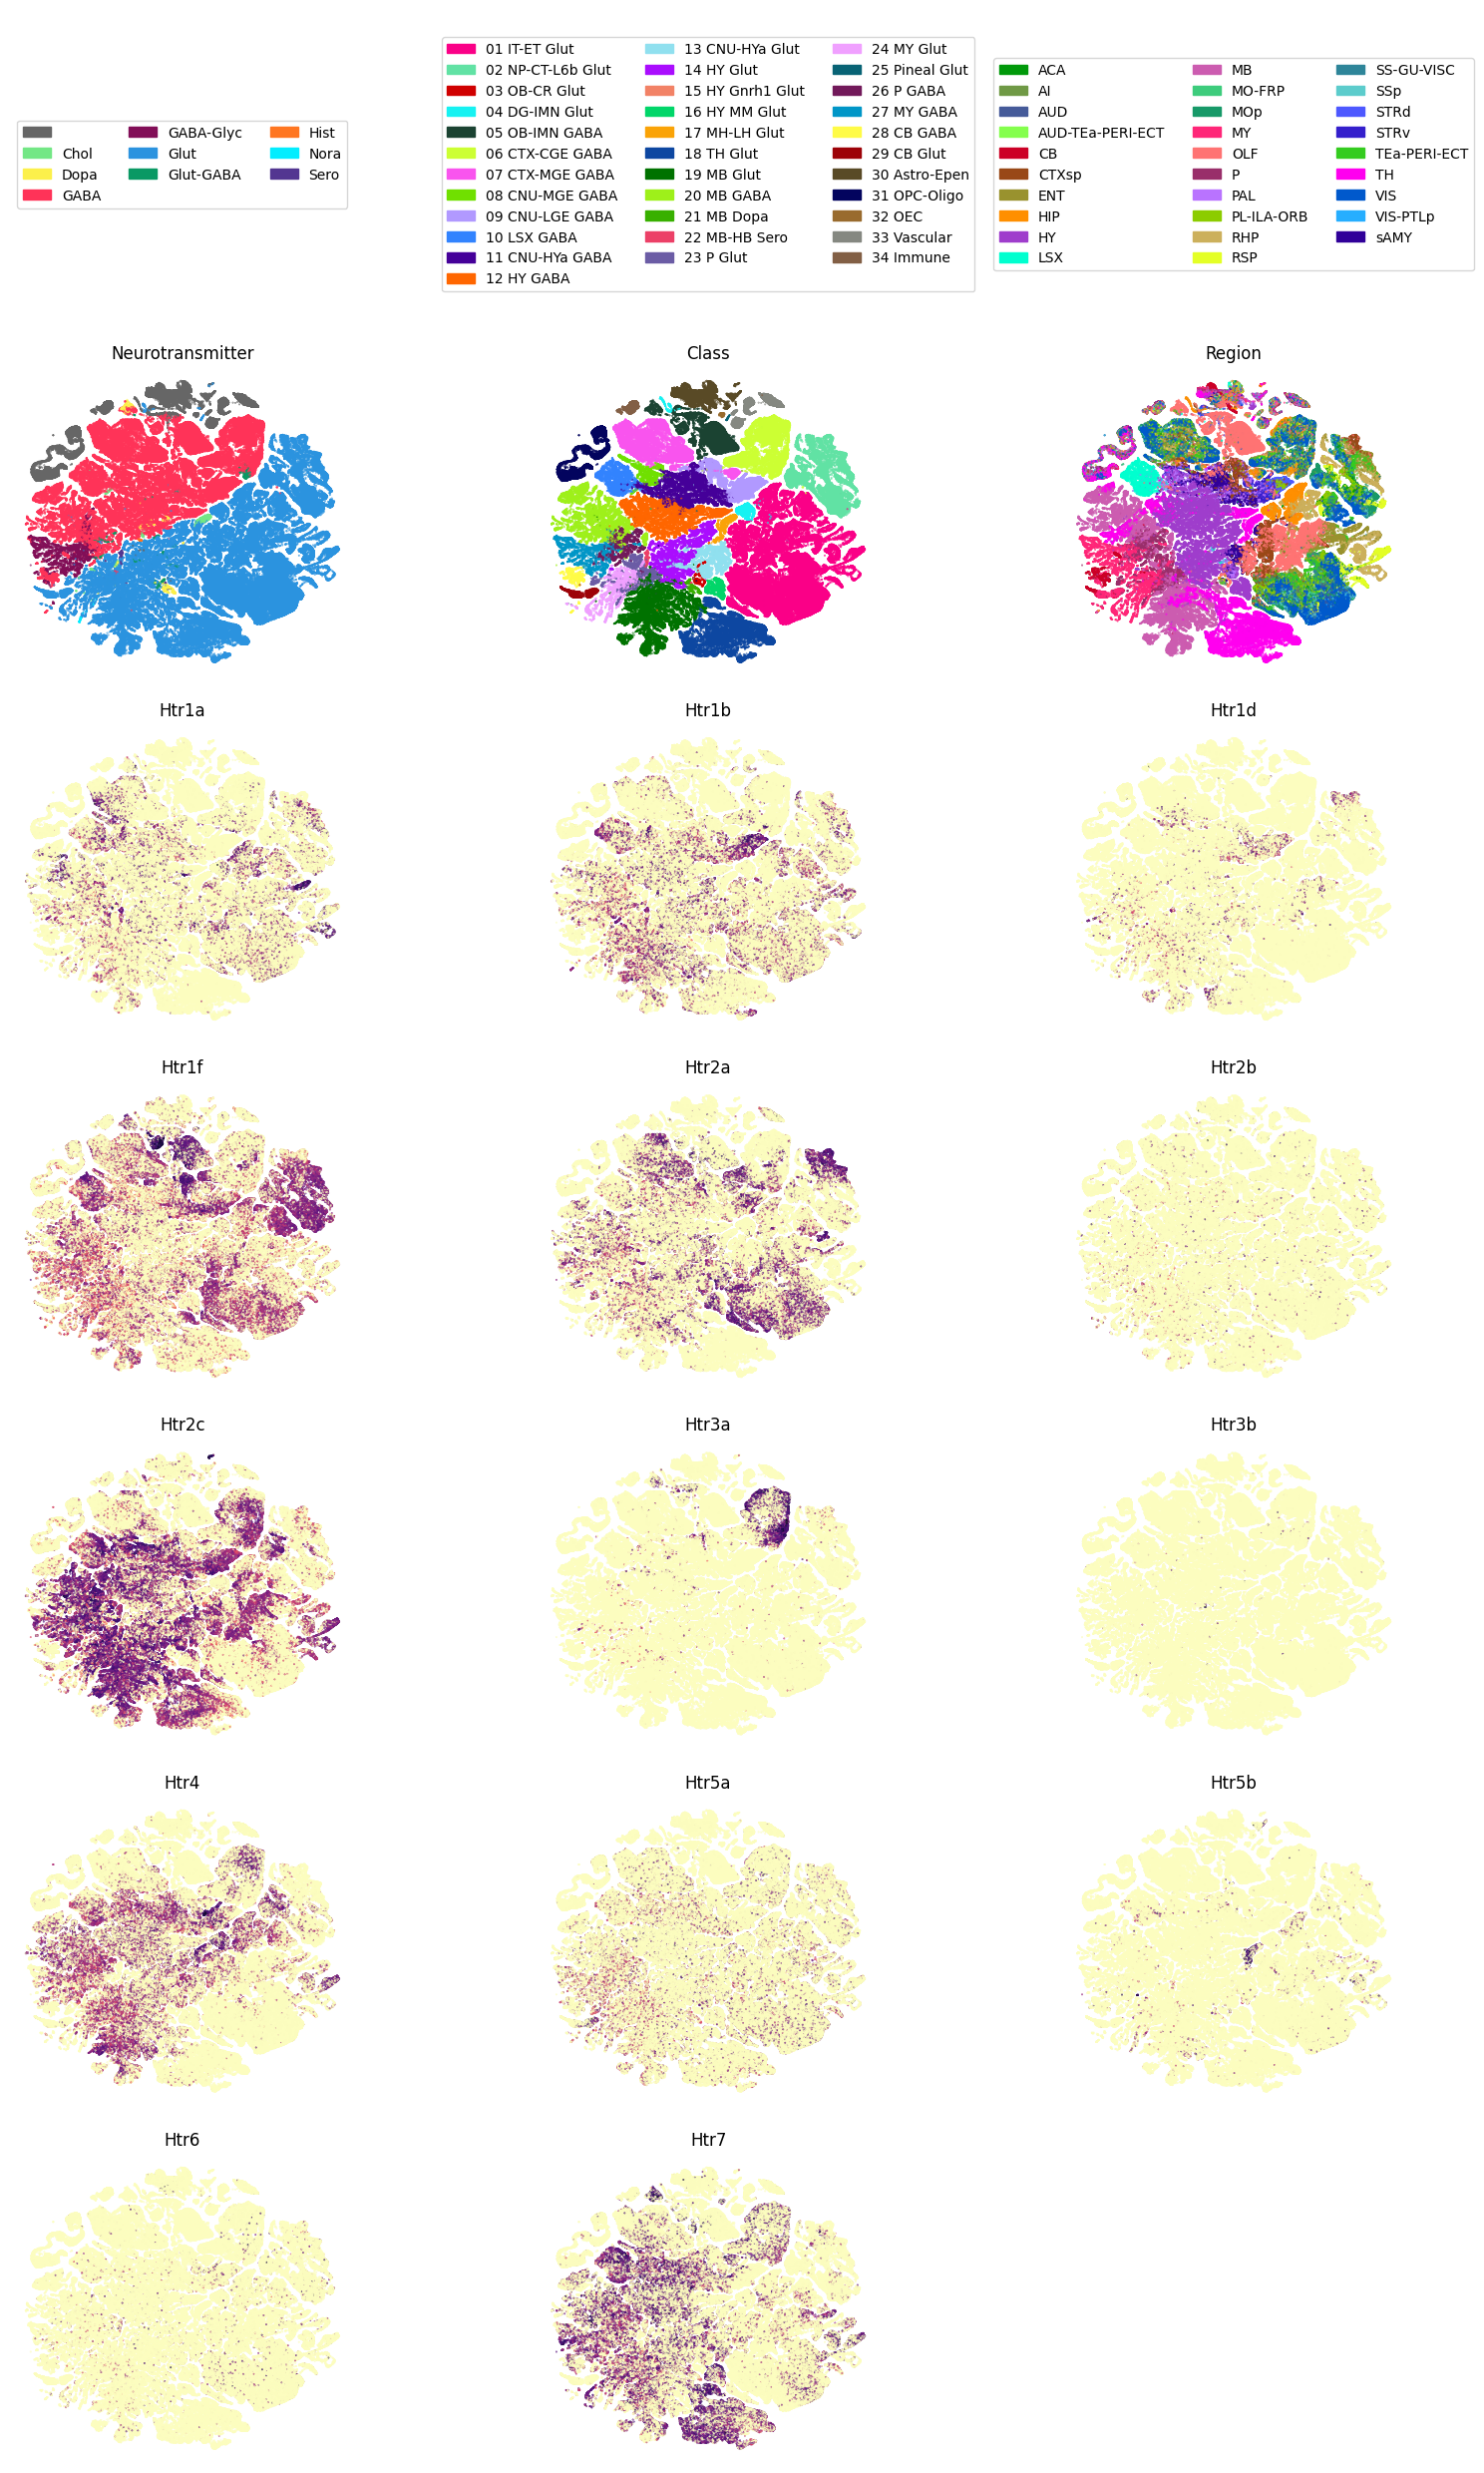

In [515]:
k = len(htrgenes) + 6

# Calculate number of rows for the grid
ncols = 3
nrows = int(np.ceil(k / ncols))

# Create a figure with the desired overall width and height
fig, axs = plt.subplots(nrows, ncols, figsize=(15,25))

for n, item in enumerate(["neurotransmitter", "class"]):      
    _ = subsampled[[item, item + "_color"]].drop_duplicates()
    _ = _.sort_values(item)
    # Create custom legend elements
    legend_elements = [mpatches.Patch(color=row[item + '_color'], label=row[item]) for x, row in _.iterrows()]
    axs[0,n].legend(handles=legend_elements, ncol=3, loc="center")

_ = subsampled[["region_of_interest_acronym", "region_of_interest_color"]].drop_duplicates()
_ = _.sort_values("region_of_interest_acronym")
# Create custom legend elements
legend_elements = [mpatches.Patch(color=row["region_of_interest_color"], label=row["region_of_interest_acronym"]) for x, row in _.iterrows()]
axs[0,2].legend(handles=legend_elements, ncol=3, loc="center")

axs[1,0].scatter(subsampled['x'], subsampled['y'], c=subsampled['neurotransmitter_color'], s=0.5, marker='.')
axs[1,0].set_title("Neurotransmitter") 
axs[1,2].scatter(subsampled['x'], subsampled['y'], c=subsampled['region_of_interest_color'], s=0.5, marker='.')
axs[1,2].set_title("Region") 
axs[1,1].scatter(subsampled['x'], subsampled['y'], c=subsampled['class_color'], s=0.5, marker='.')
axs[1,1].set_title("Class") 

for n, gene in enumerate(htrgenes):
    row = n // ncols
    col = n % ncols
    sc = axs[row + 2, col ].scatter(subsampled['x'], subsampled['y'], c=subsampled[gene], s=0.5, marker='.', cmap=plt.cm.magma_r)
    axs[row + 2, col].set_title(gene) 

for ax_row in axs:
    for ax in ax_row:
        ax.axis('off')

plt.tight_layout()

In [904]:

joined_boolean =  cell.join( exp.astype("bool") )


In [905]:
thr = exp[exp>0].quantile(.9)
joined_boolean_top_10 = cell.join( exp > thr)


# expression across regions of interest

<AxesSubplot:ylabel='region_of_interest_acronym'>

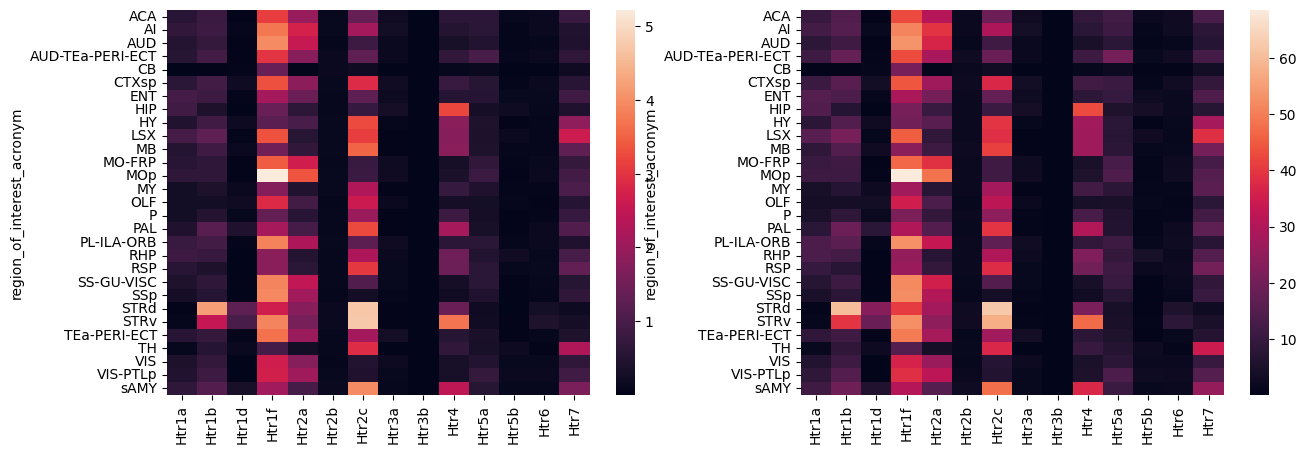

In [554]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
sns.heatmap(joined.groupby("region_of_interest_acronym")[htrgenes].mean(), yticklabels=True, ax=axs[0])
sns.heatmap(joined_boolean.groupby("region_of_interest_acronym")[htrgenes].sum().div(joined.groupby("region_of_interest_acronym").size(), axis="index") * 100,
            yticklabels=True, ax=axs[1])

<AxesSubplot:ylabel='region_of_interest_acronym'>

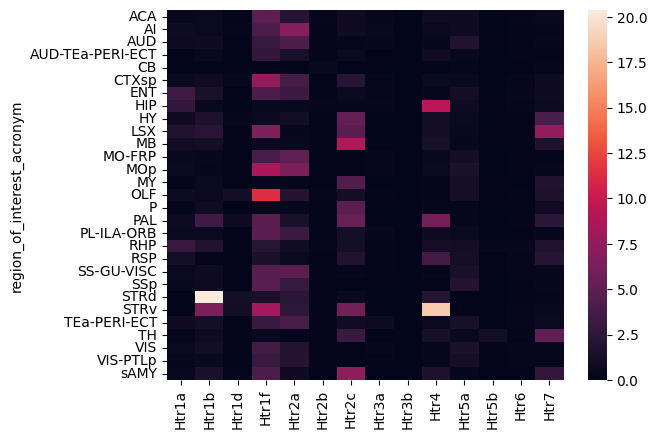

In [562]:
sns.heatmap(joined_boolean_top_10.groupby("region_of_interest_acronym")[htrgenes].sum().div(joined_boolean_top_10.groupby("region_of_interest_acronym").size(), axis="index") * 100,
            yticklabels=True)

<AxesSubplot:ylabel='division'>

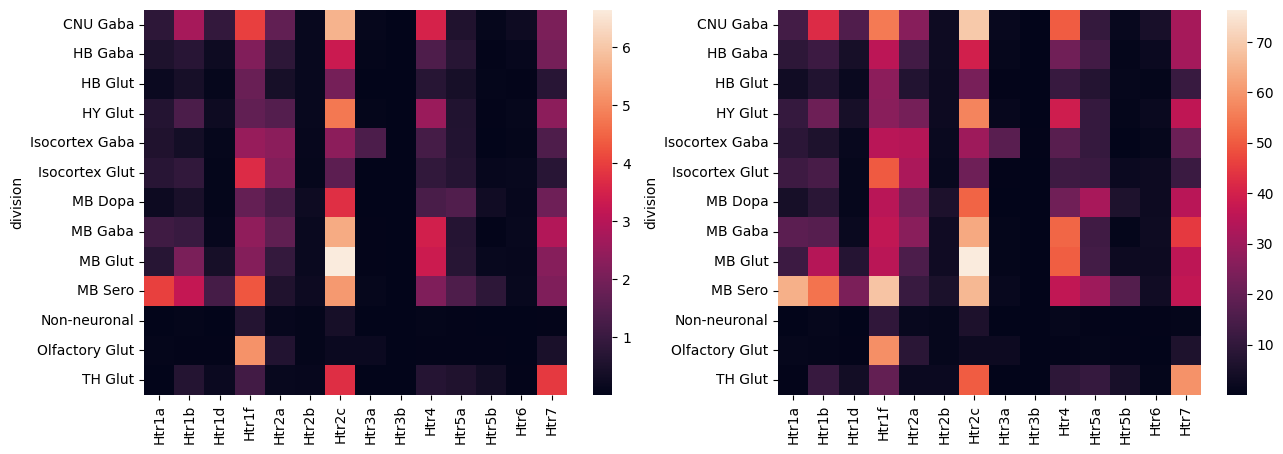

In [906]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
sns.heatmap(joined.groupby("division")[htrgenes].mean(), yticklabels=True, ax=axs[0])
sns.heatmap(joined_boolean.groupby("division")[htrgenes].sum().div(joined.groupby("division").size(), axis="index") * 100,
            yticklabels=True, ax=axs[1])

<AxesSubplot:ylabel='division'>

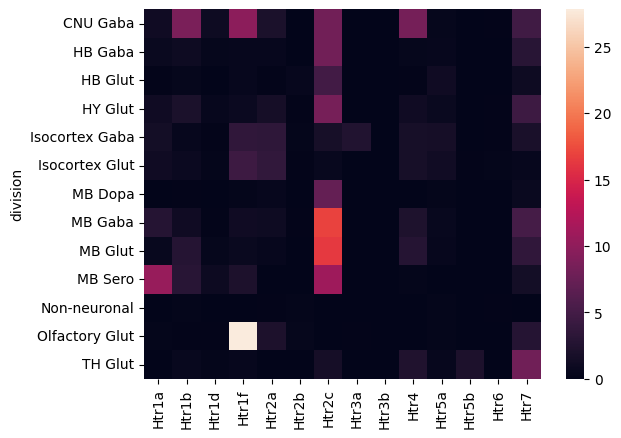

In [907]:
sns.heatmap(joined_boolean_top_10.groupby("division")[htrgenes].sum().div(joined_boolean_top_10.groupby("division").size(), axis="index") * 100,
            yticklabels=True)

# expression across classes

<AxesSubplot:ylabel='class'>

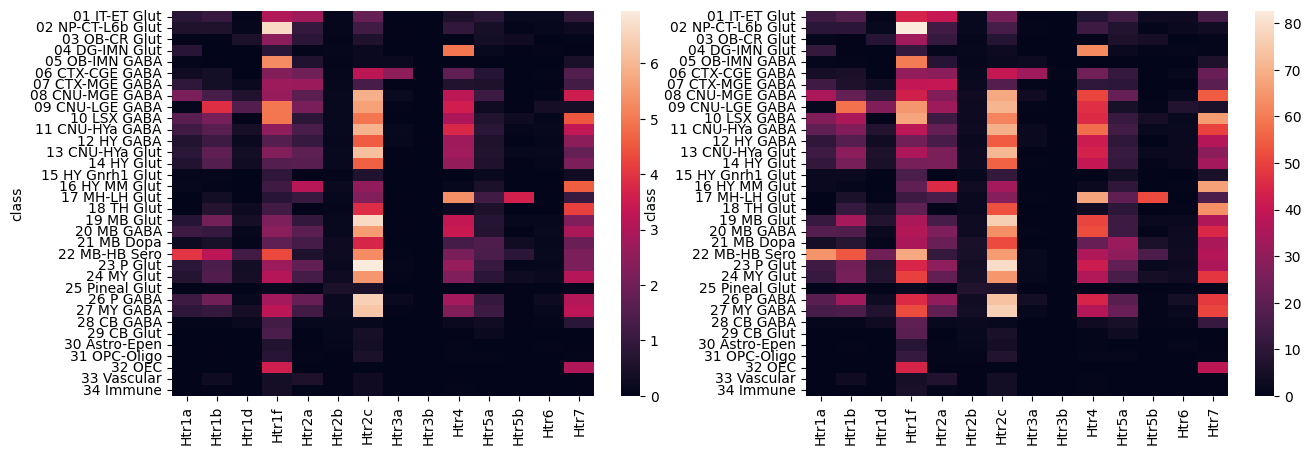

In [563]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
sns.heatmap(joined.groupby("class")[htrgenes].mean(), yticklabels=True, ax=axs[0])
sns.heatmap(joined_boolean.groupby("class")[htrgenes].sum().div(joined.groupby("class").size(), axis="index") * 100,
            yticklabels=True, ax=axs[1])

<AxesSubplot:ylabel='class'>

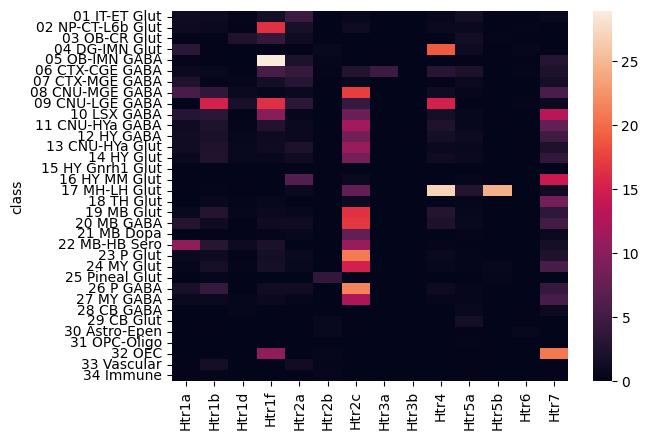

In [564]:
sns.heatmap(joined_boolean_top_10.groupby("class")[htrgenes].sum().div(joined_boolean_top_10.groupby("class").size(), axis="index") * 100,
            yticklabels=True)

# Correlation

<AxesSubplot:>

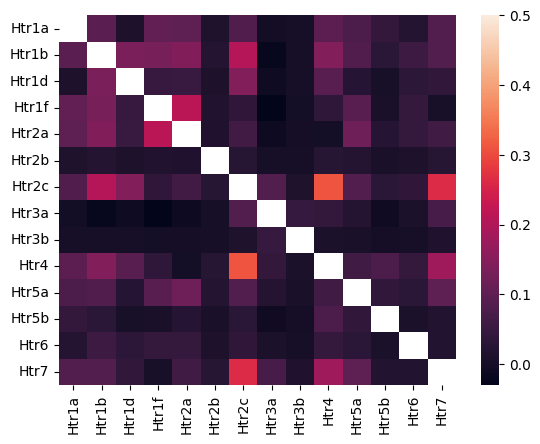

In [785]:
_ = exp.corr()
sns.heatmap(_[_<1], vmax=.5)

# Coexpression

In [831]:
cell.columns

Index(['cell_barcode', 'barcoded_cell_sample_label', 'library_label',
       'feature_matrix_label', 'entity', 'brain_section_label',
       'library_method', 'region_of_interest_acronym', 'donor_label',
       'donor_genotype', 'donor_sex', 'dataset_label', 'x', 'y',
       'cluster_alias', 'neurotransmitter', 'class', 'subclass', 'supertype',
       'cluster', 'neurotransmitter_color', 'class_color', 'subclass_color',
       'supertype_color', 'cluster_color', 'region_of_interest_order',
       'region_of_interest_color'],
      dtype='object')

In [925]:
coexp = {}
for division in tqdm(joined_boolean["division"].unique()):
    for gene_target in htrgenes:
        for gene_to_check in tqdm(htrgenes): 
            coexp[gene_target, gene_to_check, division] = joined_boolean[joined_boolean["division"]==division][[gene_target, gene_to_check]].all(axis=1).sum()/(joined_boolean[joined_boolean["division"]==division][gene_target]>0).sum()


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

In [939]:
df.to_pickle("/home/roberto/Github/synthetic_surprise/processed/colocalization.pkl")

In [941]:
df = pd.DataFrame.from_dict(coexp, orient='index', columns=['Value'])
df[['Gene1', 'Gene2', "Division"]] = pd.DataFrame(df.index.tolist(), index=df.index)
df = df.reset_index(drop=True)

# Reorder the columns for clarity
df = df[["Division",'Gene1', 'Gene2', 'Value']]


In [943]:
df = pd.read_pickle("/home/roberto/Github/synthetic_surprise/processed/colocalization.pkl")

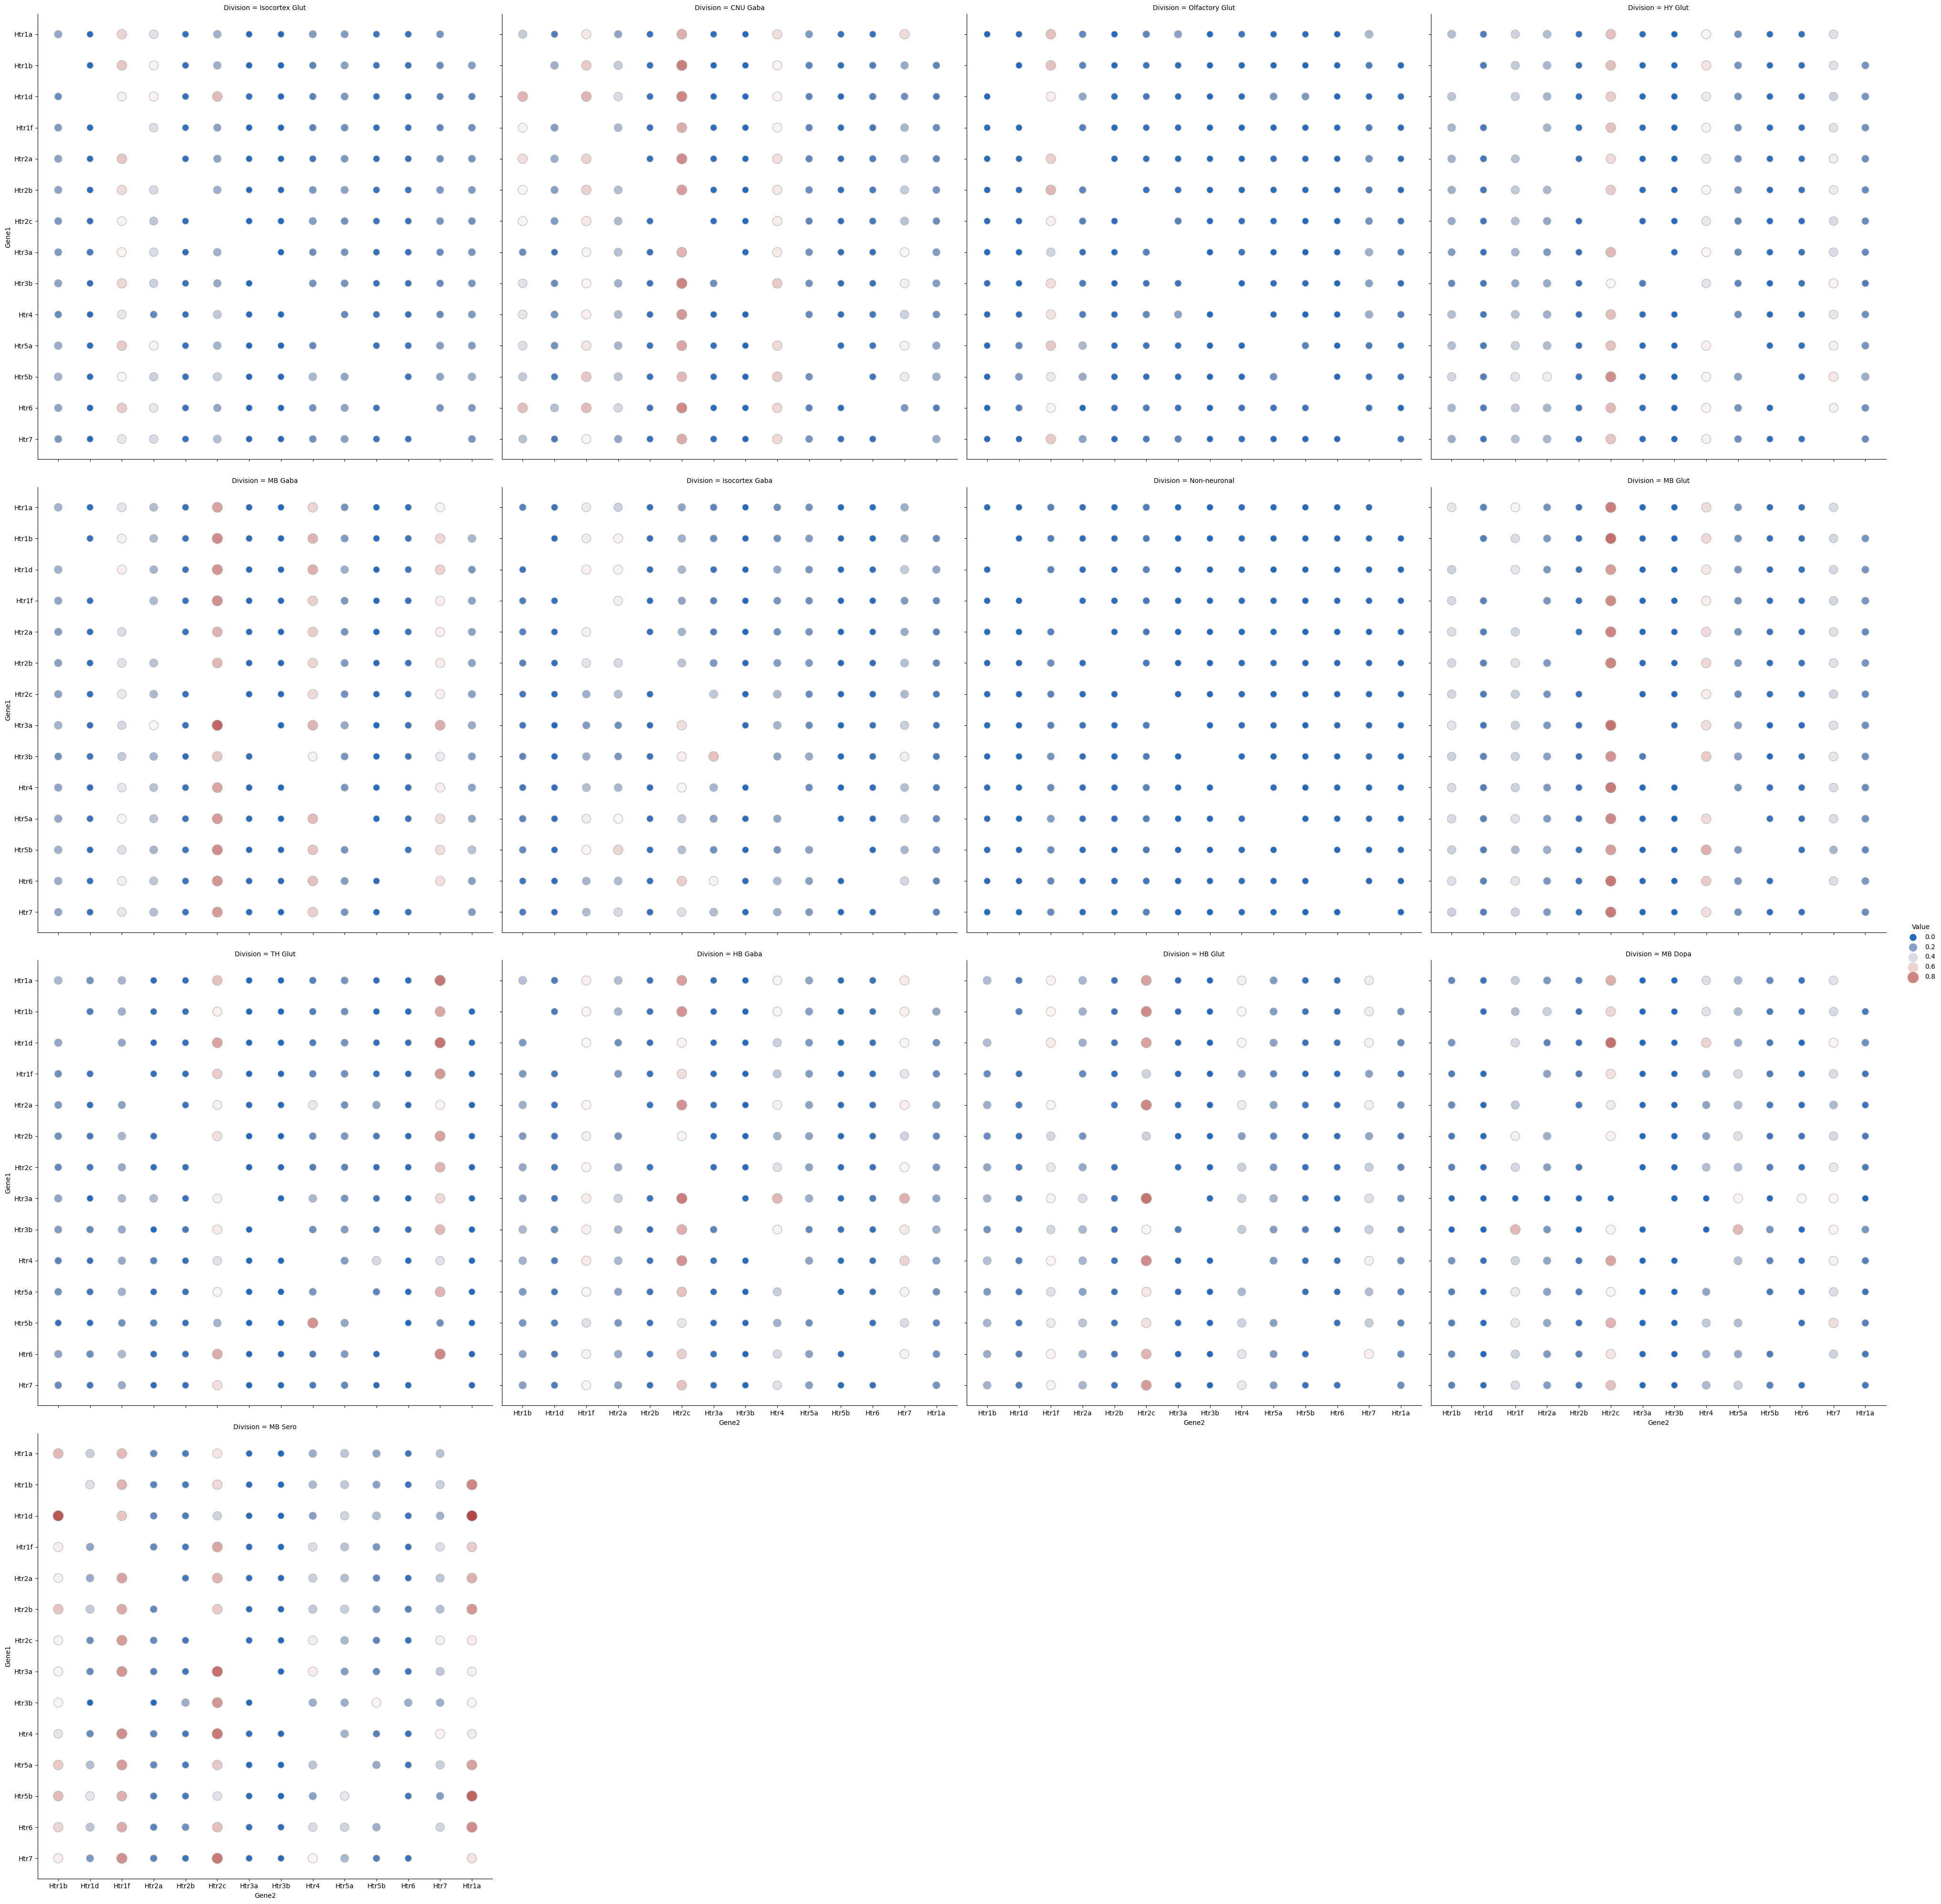

In [944]:
rg = sns.relplot(
    data=df[df["Value"]<1],
    y="Gene1", x="Gene2", hue="Value", size="Value",
    palette="vlag", hue_norm=(0, 1), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(-.2, .8), col= "Division", col_wrap=4
)
g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)

for artist in g.legend.legendHandles:
    artist.set_edgecolor(".7")



In [ ]:
coexp = {}
for gene_target in tqdm(htrgenes):
    for gene_to_check in htrgenes: 
        coexp[gene_target, gene_to_check] = joined_boolean[[gene_target, gene_to_check]].all(axis=1).sum()/(joined_boolean[gene_target]>0).sum()

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
df = pd.DataFrame.from_dict(coexp, orient='index', columns=['Value'])
df[['Gene1', 'Gene2']] = pd.DataFrame(df.index.tolist(), index=df.index)
df = df.reset_index(drop=True)

# Reorder the columns for clarity
df = df[['Gene1', 'Gene2', 'Value']]


## Percentage colocalize

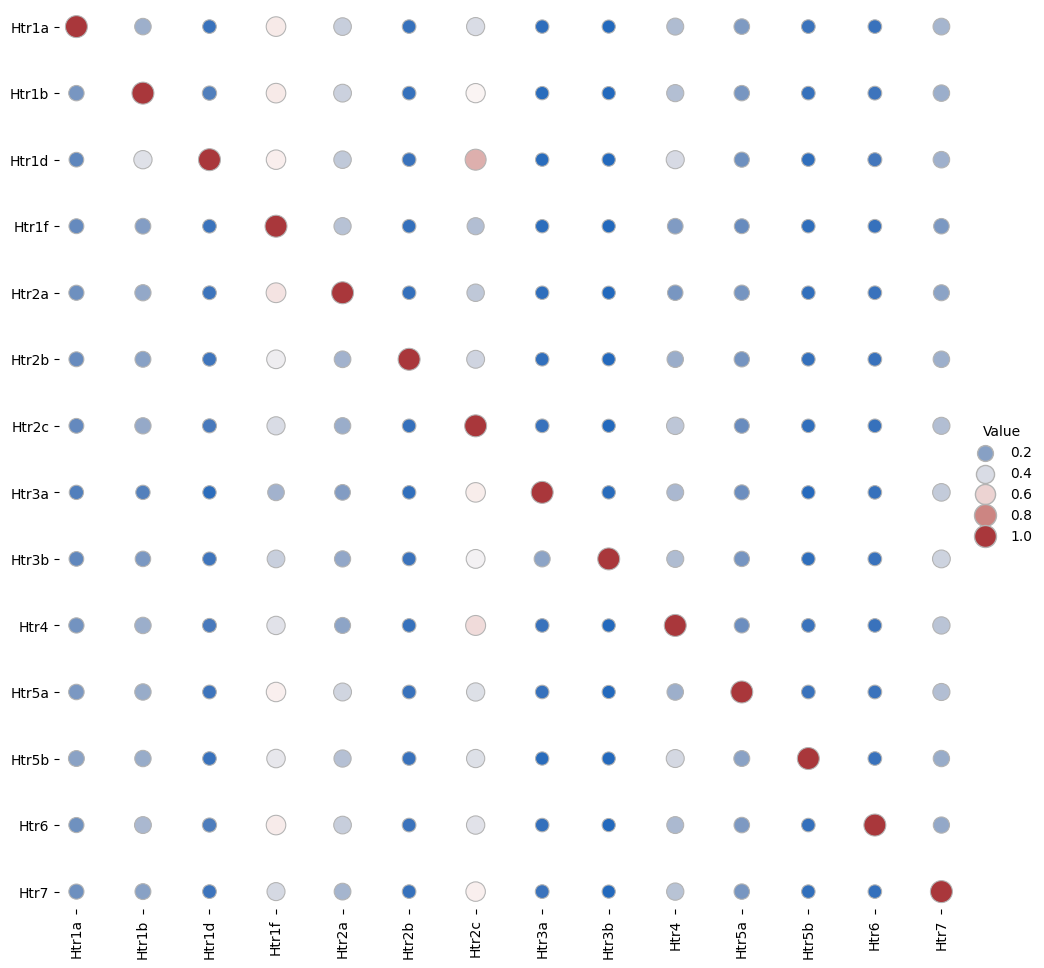

In [848]:
g = sns.relplot(
    data=df[df<1],
    y="Gene1", x="Gene2", hue="Value", size="Value",
    palette="vlag", hue_norm=(0, 1), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(-.2, .8),
)
g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)
for artist in g.legend.legendHandles:
    artist.set_edgecolor(".7")

# Cortex expression

### GABA

In [617]:
sub_joined = joined[joined["class"].isin(["06 CTX-CGE GABA",'07 CTX-MGE GABA'])].sort_values("supertype")
sub_joined_boolean = joined_boolean[joined_boolean["class"].isin(["06 CTX-CGE GABA",'07 CTX-MGE GABA'])].sort_values("supertype")
sub_joined_boolean_top_10 = joined_boolean_top_10[joined_boolean_top_10["class"].isin(["06 CTX-CGE GABA",'07 CTX-MGE GABA'])].sort_values("supertype")

<AxesSubplot:ylabel='subclass'>

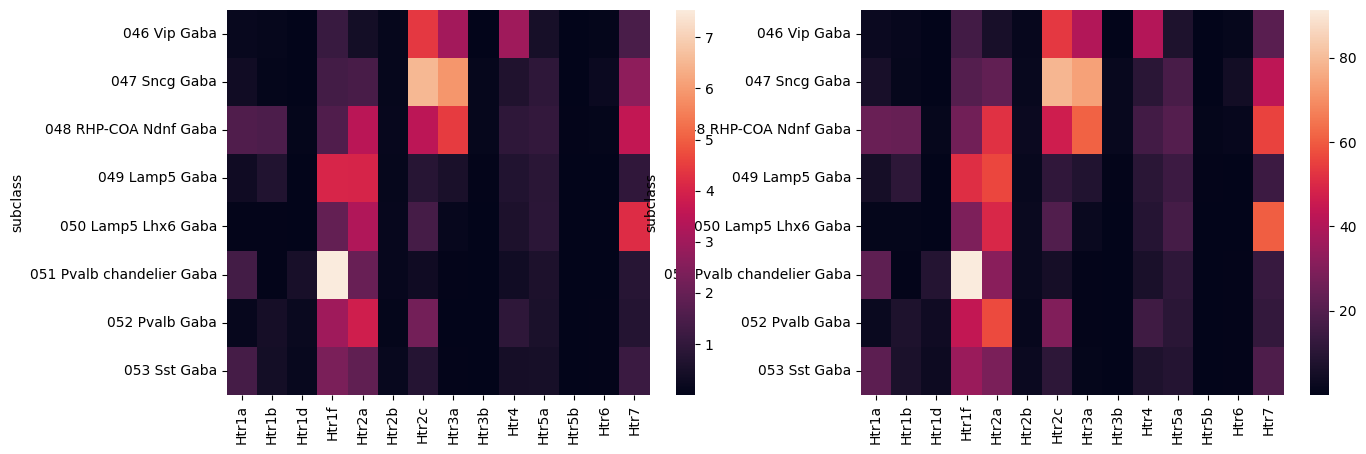

In [577]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
sns.heatmap(sub_joined.groupby("subclass")[htrgenes].mean(), yticklabels=True, ax=axs[0])
sns.heatmap(sub_joined_boolean.groupby("subclass")[htrgenes].sum().div(sub_joined_boolean.groupby("subclass").size(), axis="index") * 100,
            yticklabels=True, ax=axs[1])

<AxesSubplot:ylabel='subclass'>

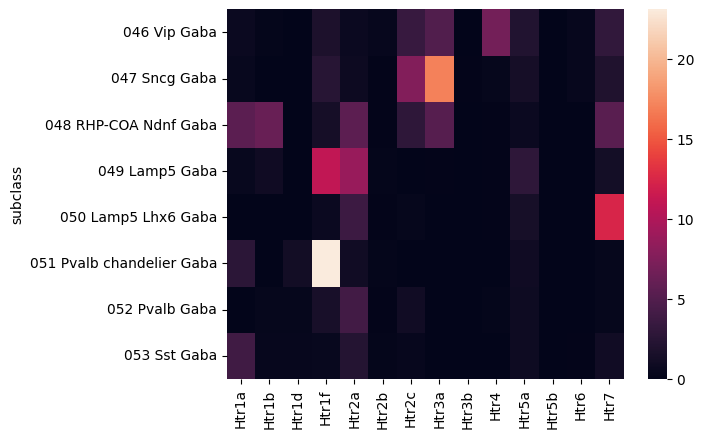

In [580]:
sns.heatmap(sub_joined_boolean_top_10.groupby("subclass")[htrgenes].sum().div(sub_joined_boolean_top_10.groupby("subclass").size(), axis="index") * 100,
            yticklabels=True)

<AxesSubplot:ylabel='supertype'>

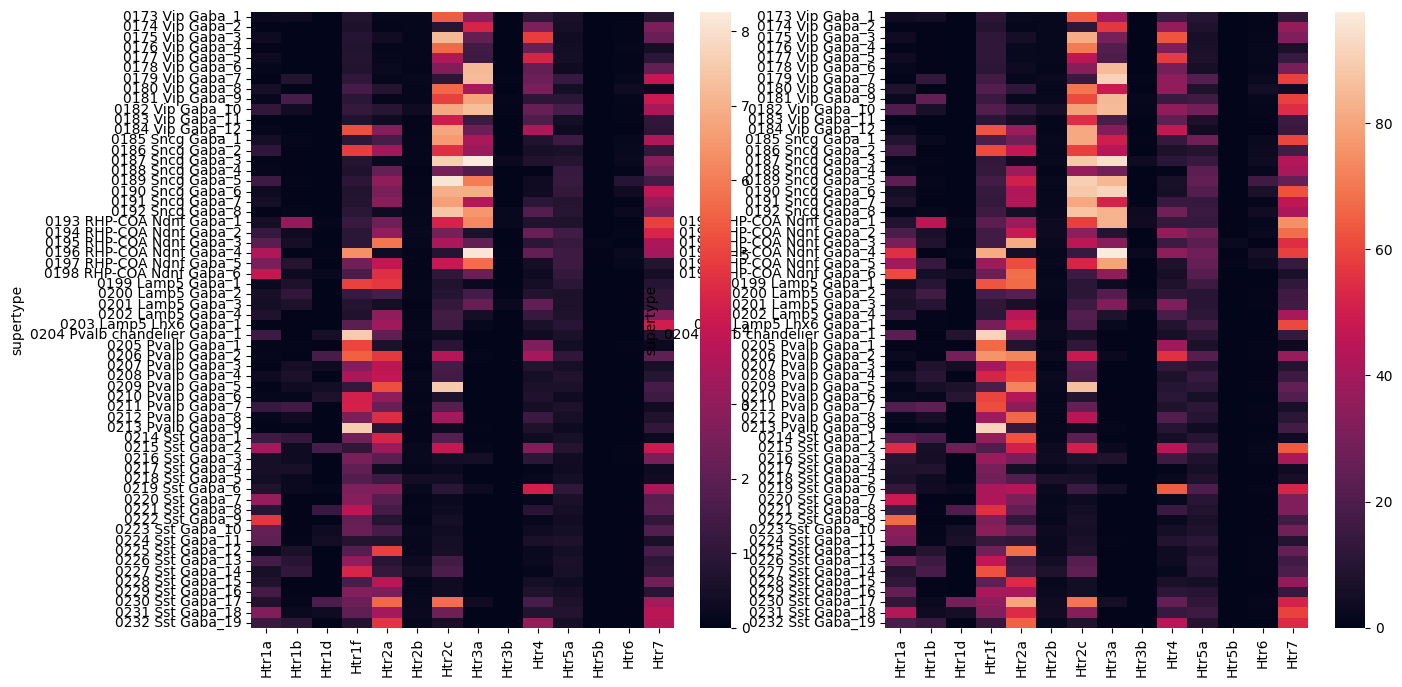

In [584]:
fig, axs = plt.subplots(1,2, figsize=(15,8))
sns.heatmap(sub_joined.groupby("supertype")[htrgenes].mean(), yticklabels=True, ax=axs[0])
sns.heatmap(sub_joined_boolean.groupby("supertype")[htrgenes].sum().div(sub_joined_boolean.groupby("supertype").size(), axis="index") * 100,
            yticklabels=True, ax=axs[1])

<AxesSubplot:ylabel='supertype'>

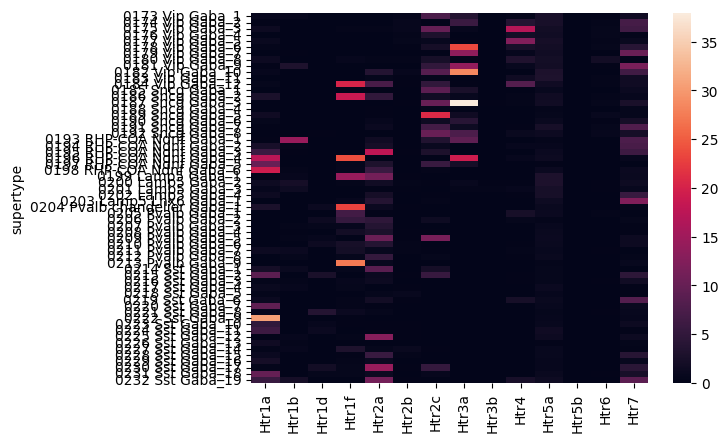

In [849]:
sns.heatmap(sub_joined_boolean_top_10.groupby("supertype")[htrgenes].sum().div(sub_joined_boolean_top_10.groupby("supertype").size(), axis="index") * 100,
            yticklabels=True)

In [678]:
_ = _.stack().reset_index(name="measure")

In [684]:
_

number_cells  percentage_cells  expression
subclass                                                             
049 Lamp5 Gaba                    40881          0.750330    4.862774
052 Pvalb Gaba                    25111          0.593444    4.579923
053 Sst Gaba                      10027          0.148795    5.002824
050 Lamp5 Lhx6 Gaba                4178          0.468754    4.670452
048 RHP-COA Ndnf Gaba              1644          0.504140    5.288515
047 Sncg Gaba                       769          0.040817    4.862179
051 Pvalb chandelier Gaba           309          0.089049    4.182285

### Glut

In [859]:
sub_joined = joined[joined["class"].isin(['01 IT-ET Glut','02 NP-CT-L6b Glut'])].sort_values("supertype")
sub_joined_boolean = joined_boolean[joined_boolean["class"].isin(['01 IT-ET Glut','02 NP-CT-L6b Glut'])].sort_values("supertype")
sub_joined_boolean_top_10 = joined_boolean_top_10[joined_boolean_top_10["class"].isin(['01 IT-ET Glut','02 NP-CT-L6b Glut'])].sort_values("supertype")

<AxesSubplot:ylabel='subclass'>

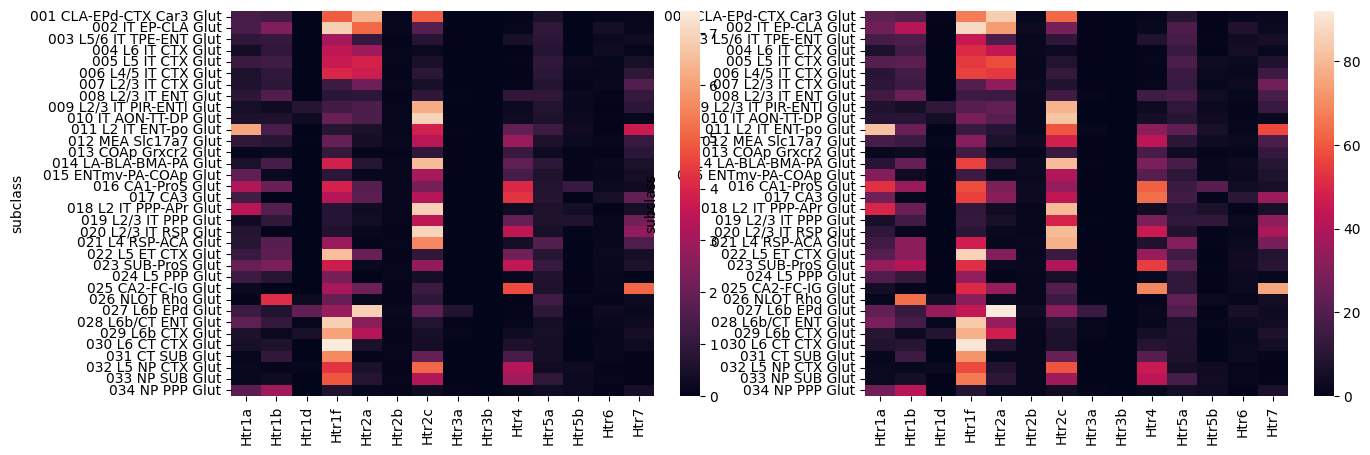

In [610]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
sns.heatmap(sub_joined.groupby("subclass")[htrgenes].mean(), yticklabels=True, ax=axs[0])
sns.heatmap(sub_joined_boolean.groupby("subclass")[htrgenes].sum().div(sub_joined_boolean.groupby("subclass").size(), axis="index") * 100,
            yticklabels=True, ax=axs[1])

<AxesSubplot:ylabel='subclass'>

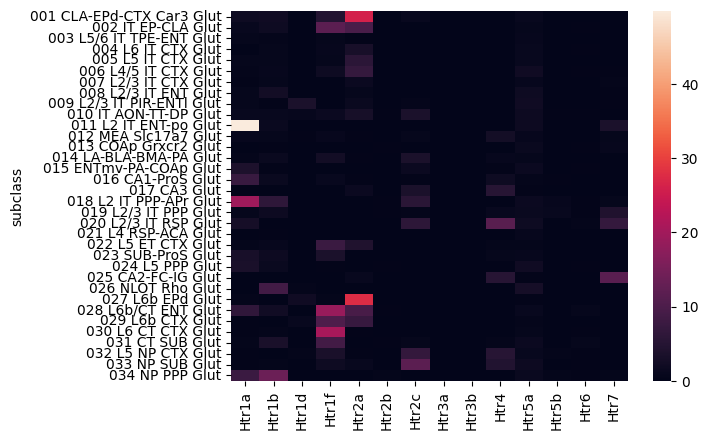

In [611]:
sns.heatmap(sub_joined_boolean_top_10.groupby("subclass")[htrgenes].sum().div(sub_joined_boolean_top_10.groupby("subclass").size(), axis="index") * 100,
            yticklabels=True)

<AxesSubplot:ylabel='subclass'>

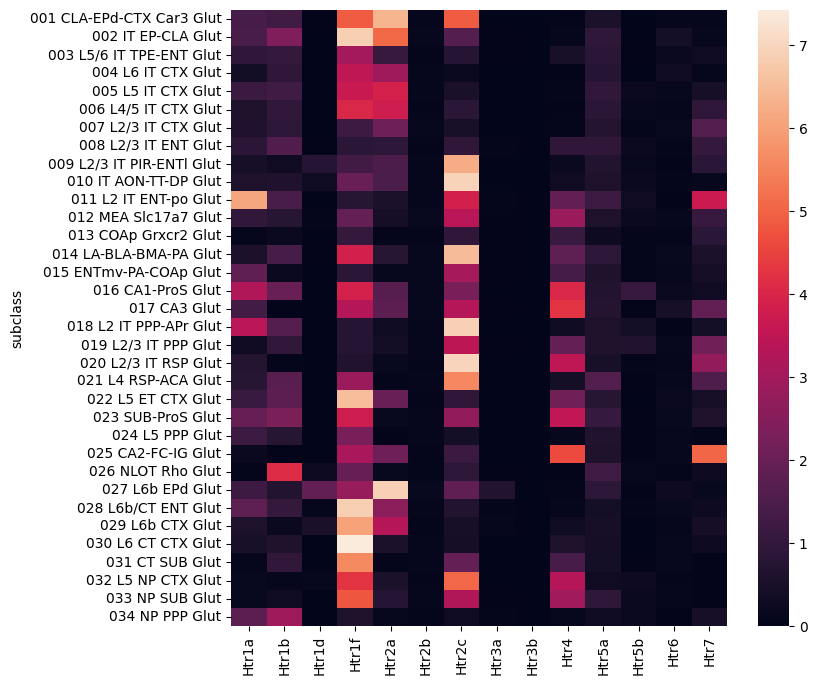

In [860]:
fig, axs = plt.subplots(1, figsize=(8,8))
sns.heatmap(sub_joined.groupby("subclass")[htrgenes].mean(), yticklabels=True, ax=axs)


<AxesSubplot:ylabel='subclass'>

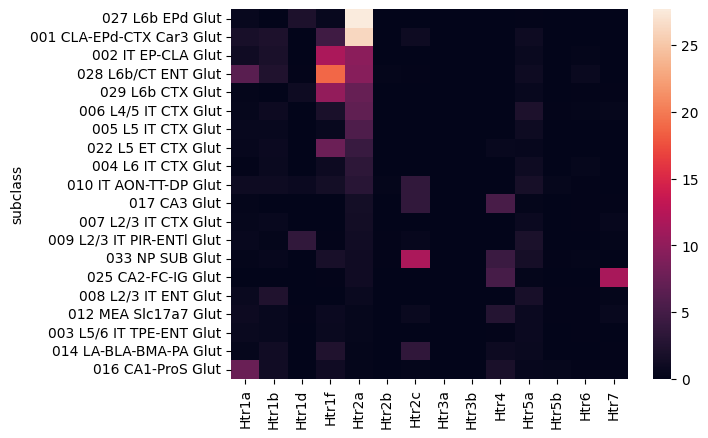

In [861]:
sns.heatmap(sub_joined_boolean_top_10.groupby("subclass")[htrgenes].sum().div(sub_joined_boolean_top_10.groupby("subclass").size(), axis="index").sort_values("Htr2a", ascending=False).head(20)*100)

In [865]:
np.sort(cell["class"].unique())

array(['01 IT-ET Glut', '02 NP-CT-L6b Glut', '03 OB-CR Glut',
       '04 DG-IMN Glut', '05 OB-IMN GABA', '06 CTX-CGE GABA',
       '07 CTX-MGE GABA', '08 CNU-MGE GABA', '09 CNU-LGE GABA',
       '10 LSX GABA', '11 CNU-HYa GABA', '12 HY GABA', '13 CNU-HYa Glut',
       '14 HY Glut', '15 HY Gnrh1 Glut', '16 HY MM Glut', '17 MH-LH Glut',
       '18 TH Glut', '19 MB Glut', '20 MB GABA', '21 MB Dopa',
       '22 MB-HB Sero', '23 P Glut', '24 MY Glut', '25 Pineal Glut',
       '26 P GABA', '27 MY GABA', '28 CB GABA', '29 CB Glut',
       '30 Astro-Epen', '31 OPC-Oligo', '32 OEC', '33 Vascular',
       '34 Immune'], dtype=object)

In [872]:
cell[cell["class"]=='08 CNU-MGE GABA']["region_of_interest_acronym"].value_counts()

PAL                 7974
sAMY                2659
HY                  2346
STRv                1165
STRd                 806
CTXsp                763
MOp                  560
AI                   367
VIS                  348
PL-ILA-ORB           293
OLF                  221
TEa-PERI-ECT         213
SS-GU-VISC           184
LSX                  155
AUD                  142
ACA                  133
SSp                  129
ENT                  103
MO-FRP                85
VIS-PTLp              46
AUD-TEa-PERI-ECT      36
RSP                   35
RHP                   34
TH                    28
HIP                   24
Name: region_of_interest_acronym, dtype: int64

In [867]:
roi

label  \
acronym                                  
MO-FRP                      WMB-MO-FRP   
MOp                            WMB-MOp   
SS-GU-VISC              WMB-SS-GU-VISC   
SSp                            WMB-SSp   
AUD                            WMB-AUD   
AUD-TEa-PERI-ECT  WMB-AUD-TEa-PERI-ECT   
VIS-PTLp                  WMB-VIS-PTLp   
VIS                            WMB-VIS   
ACA                            WMB-ACA   
PL-ILA-ORB              WMB-PL-ILA-ORB   
AI                              WMB-AI   
RSP                            WMB-RSP   
TEa-PERI-ECT          WMB-TEa-PERI-ECT   
OLF                            WMB-OLF   
HIP                            WMB-HIP   
RHP                            WMB-RHP   
ENT                            WMB-ENT   
CTXsp                        WMB-CTXsp   
STRd                          WMB-STRd   
STRv                          WMB-STRv   
LSX                            WMB-LSX   
sAMY                          WMB-sAMY   
PAL                            WMB-PAL   
TH                              WMB-TH   
HY                              WMB-HY   
MB                              WMB-MB   
P                                WMB-P   
MY                              WMB-MY   
CB                              WMB-CB   

                                                           name  \
acronym                                                           
MO-FRP                               Somatomotor - Frontal pole   
MOp                                          Primary motor area   
SS-GU-VISC               Somatosensory/gustatory/visceral areas   
SSp                                  Primary somatosensory area   
AUD                                              Auditory areas   
AUD-TEa-PERI-ECT  Auditory/temporal/perirhinal/ectorhinal areas   
VIS-PTLp                       Visual/posterior parietal  areas   
VIS                                                Visual areas   
ACA                                     Anterior cingulate area   
PL-ILA-ORB                 Prelimbic/infralimbic/orbital areas    
AI                                       Agranular insular area   
RSP                                          Retrosplenial area   
TEa-PERI-ECT              Temporal/perirhinal/ectorhinal areas    
OLF                                             Olfactory areas   
HIP                                          Hippocampal region   
RHP                                     Retrohippocampal region   
ENT                                             Entorhinal area   
CTXsp                                         Cortical subplate   
STRd                                     Striatum dorsal region   
STRv                                    Striatum ventral region   
LSX                                      Lateral septal complex   
sAMY                             Striatum-like amygdalar nuclei   
PAL                                                    Pallidum   
TH                                                     Thalamus   
HY                                                 Hypothalamus   
MB                                                     Midbrain   
P                                                          Pons   
MY                                                      Medulla   
CB                                                   Cerebellum   

                  region_of_interest_order region_of_interest_color  
acronym                                                              
MO-FRP                                   0                  #3DCC7C  
MOp                                      1                  #179968  
SS-GU-VISC                               2                  #2E8599  
SSp                                      3                  #5CCCCC  
AUD                                      4                  #455A99  
AUD-TEa-PERI-ECT                         5                  #84FF4D  
VIS-PTLp                                 6                  #26AEFF  
VIS                   

# CNU gaba

In [875]:
sub_joined = joined[joined["class"].isin([ '08 CNU-MGE GABA', '09 CNU-LGE GABA',
       '10 LSX GABA', '11 CNU-HYa GABA'])].sort_values("supertype")
sub_joined_boolean = joined_boolean[joined_boolean["class"].isin(['08 CNU-MGE GABA', '09 CNU-LGE GABA',
       '10 LSX GABA', '11 CNU-HYa GABA'])].sort_values("supertype")
sub_joined_boolean_top_10 = joined_boolean_top_10[joined_boolean_top_10["class"].isin(['08 CNU-MGE GABA', '09 CNU-LGE GABA',
       '10 LSX GABA', '11 CNU-HYa GABA'])].sort_values("supertype")

<AxesSubplot:ylabel='subclass'>

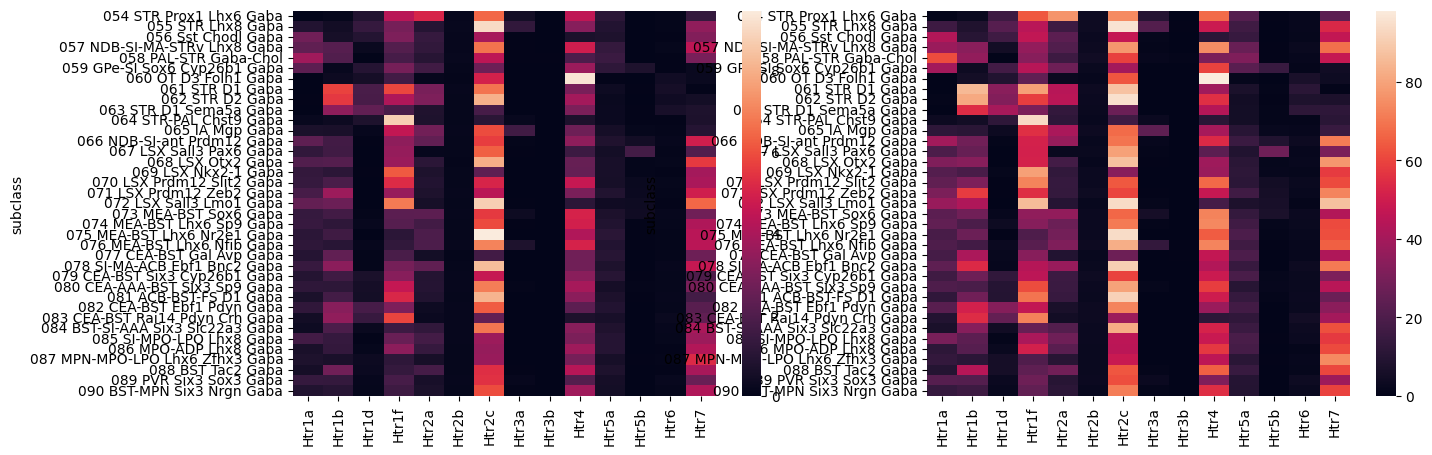

In [876]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
sns.heatmap(sub_joined.groupby("subclass")[htrgenes].mean(), yticklabels=True, ax=axs[0])
sns.heatmap(sub_joined_boolean.groupby("subclass")[htrgenes].sum().div(sub_joined_boolean.groupby("subclass").size(), axis="index") * 100,
            yticklabels=True, ax=axs[1])

<AxesSubplot:ylabel='subclass'>

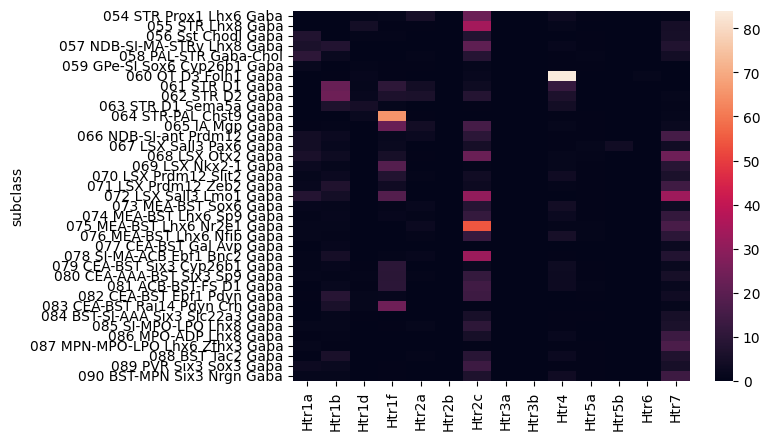

In [877]:
sns.heatmap(sub_joined_boolean_top_10.groupby("subclass")[htrgenes].sum().div(sub_joined_boolean_top_10.groupby("subclass").size(), axis="index") * 100,
            yticklabels=True)

# DG glut

In [879]:
sub_joined = joined[joined["class"].isin([ '04 DG-IMN Glut'])].sort_values("supertype")
sub_joined_boolean = joined_boolean[joined_boolean["class"].isin(['04 DG-IMN Glut'])].sort_values("supertype")
sub_joined_boolean_top_10 = joined_boolean_top_10[joined_boolean_top_10["class"].isin(['04 DG-IMN Glut'])].sort_values("supertype")

<AxesSubplot:ylabel='supertype'>

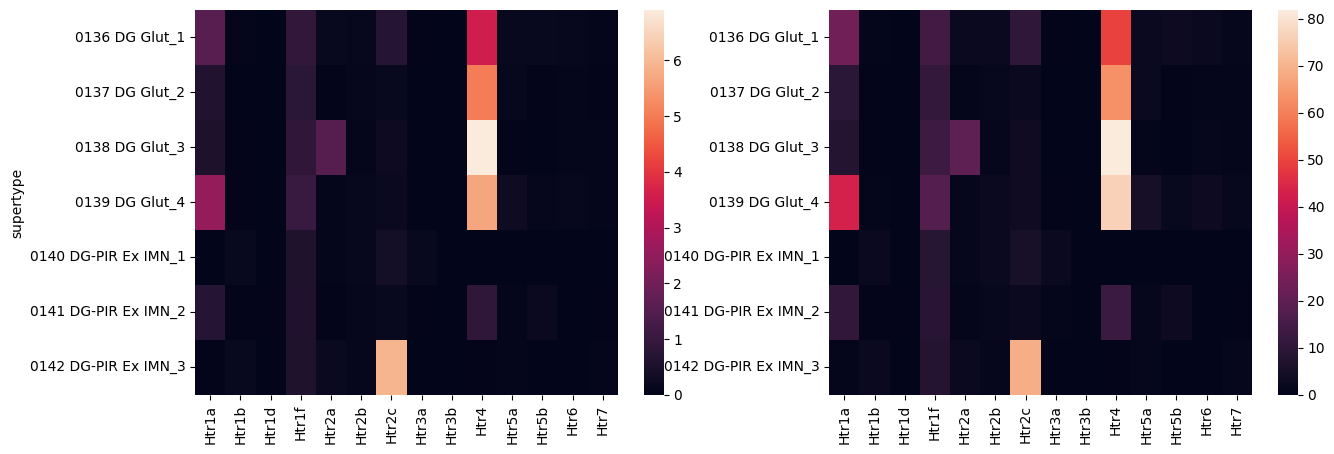

In [882]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
sns.heatmap(sub_joined.groupby("supertype")[htrgenes].mean(), yticklabels=True, ax=axs[0])
sns.heatmap(sub_joined_boolean.groupby("supertype")[htrgenes].sum().div(sub_joined_boolean.groupby("supertype").size(), axis="index") * 100,
            yticklabels=True, ax=axs[1])

<AxesSubplot:ylabel='supertype'>

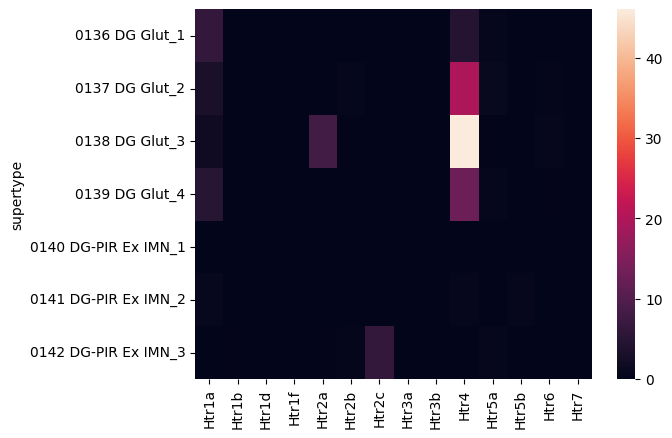

In [883]:
sns.heatmap(sub_joined_boolean_top_10.groupby("supertype")[htrgenes].sum().div(sub_joined_boolean_top_10.groupby("supertype").size(), axis="index") * 100,
            yticklabels=True)

# HY glut

In [885]:
sub_joined = joined[joined["class"].isin([ '13 CNU-HYa Glut',
       '14 HY Glut', '15 HY Gnrh1 Glut', '16 HY MM Glut'])].sort_values("supertype")
sub_joined_boolean = joined_boolean[joined_boolean["class"].isin(['13 CNU-HYa Glut',
       '14 HY Glut', '15 HY Gnrh1 Glut', '16 HY MM Glut'])].sort_values("supertype")
sub_joined_boolean_top_10 = joined_boolean_top_10[joined_boolean_top_10["class"].isin(['13 CNU-HYa Glut',
       '14 HY Glut', '15 HY Gnrh1 Glut', '16 HY MM Glut'])].sort_values("supertype")

<AxesSubplot:ylabel='subclass'>

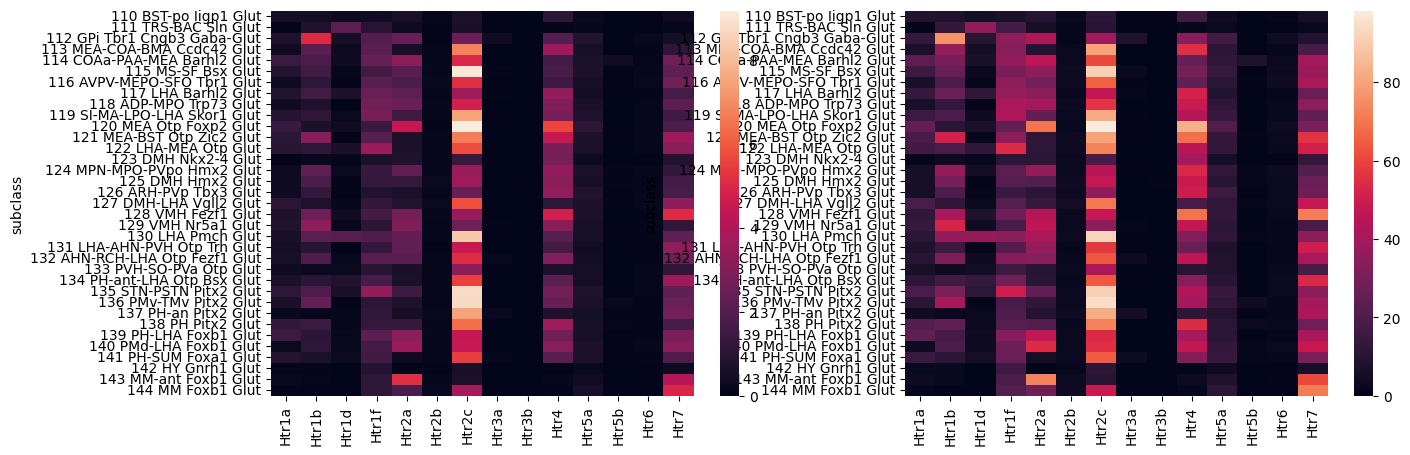

In [886]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
sns.heatmap(sub_joined.groupby("subclass")[htrgenes].mean(), yticklabels=True, ax=axs[0])
sns.heatmap(sub_joined_boolean.groupby("subclass")[htrgenes].sum().div(sub_joined_boolean.groupby("subclass").size(), axis="index") * 100,
            yticklabels=True, ax=axs[1])

<AxesSubplot:ylabel='subclass'>

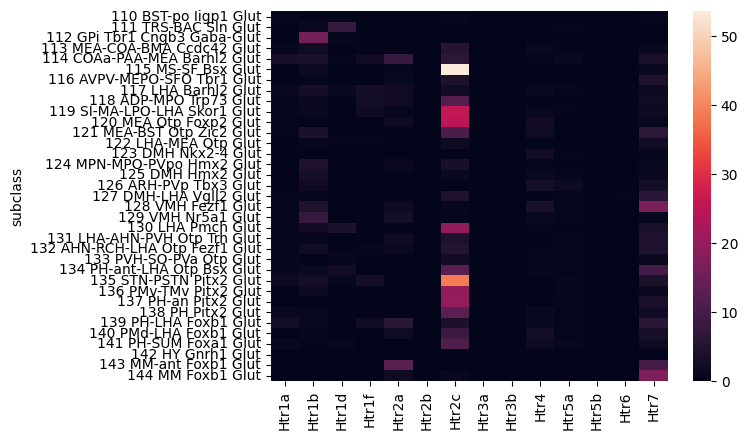

In [887]:
sns.heatmap(sub_joined_boolean_top_10.groupby("subclass")[htrgenes].sum().div(sub_joined_boolean_top_10.groupby("subclass").size(), axis="index") * 100,
            yticklabels=True)

# HY gaba

In [888]:
sub_joined = joined[joined["class"].isin([ '12 HY GABA'])].sort_values("supertype")
sub_joined_boolean = joined_boolean[joined_boolean["class"].isin(['12 HY GABA'])].sort_values("supertype")
sub_joined_boolean_top_10 = joined_boolean_top_10[joined_boolean_top_10["class"].isin(['12 HY GABA'])].sort_values("supertype")

<AxesSubplot:ylabel='subclass'>

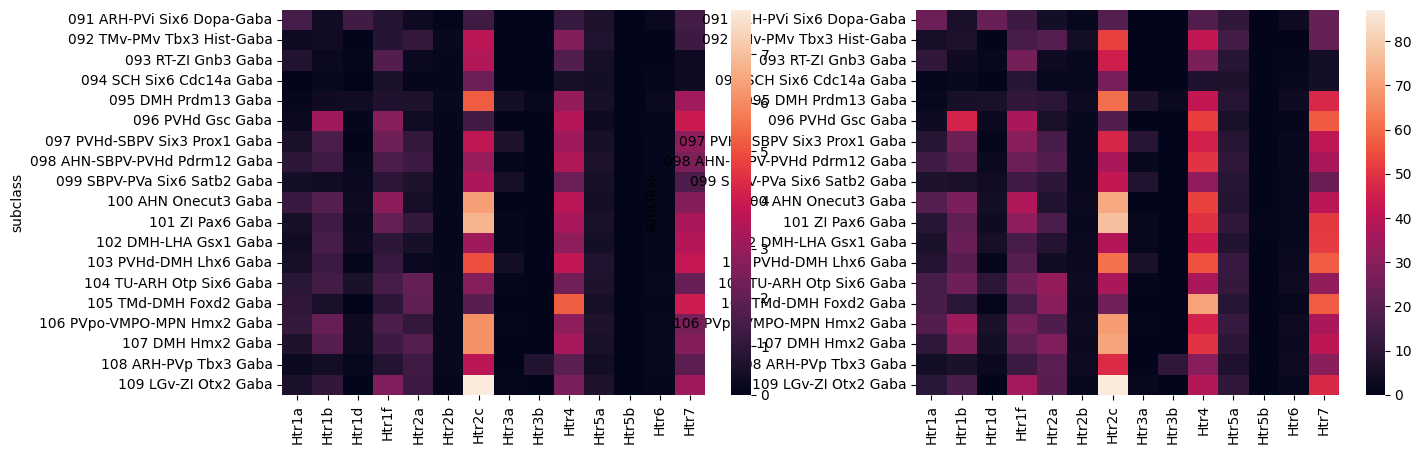

In [889]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
sns.heatmap(sub_joined.groupby("subclass")[htrgenes].mean(), yticklabels=True, ax=axs[0])
sns.heatmap(sub_joined_boolean.groupby("subclass")[htrgenes].sum().div(sub_joined_boolean.groupby("subclass").size(), axis="index") * 100,
            yticklabels=True, ax=axs[1])

<AxesSubplot:ylabel='subclass'>

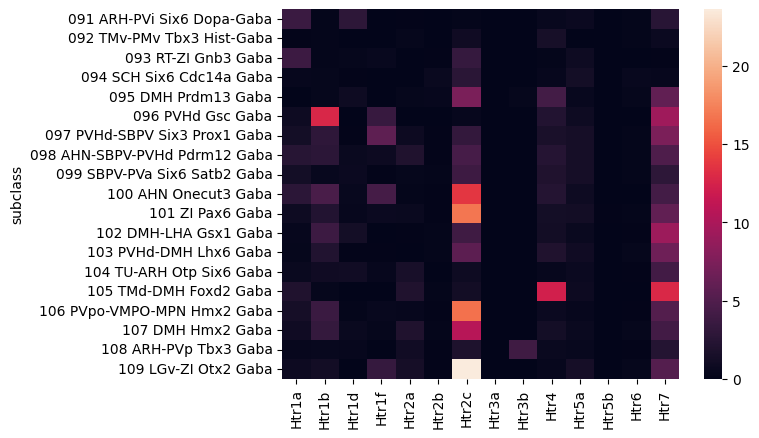

In [890]:
sns.heatmap(sub_joined_boolean_top_10.groupby("subclass")[htrgenes].sum().div(sub_joined_boolean_top_10.groupby("subclass").size(), axis="index") * 100,
            yticklabels=True)

# HY gaba

In [888]:
sub_joined = joined[joined["class"].isin([ '12 HY GABA'])].sort_values("supertype")
sub_joined_boolean = joined_boolean[joined_boolean["class"].isin(['12 HY GABA'])].sort_values("supertype")
sub_joined_boolean_top_10 = joined_boolean_top_10[joined_boolean_top_10["class"].isin(['12 HY GABA'])].sort_values("supertype")

<AxesSubplot:ylabel='subclass'>

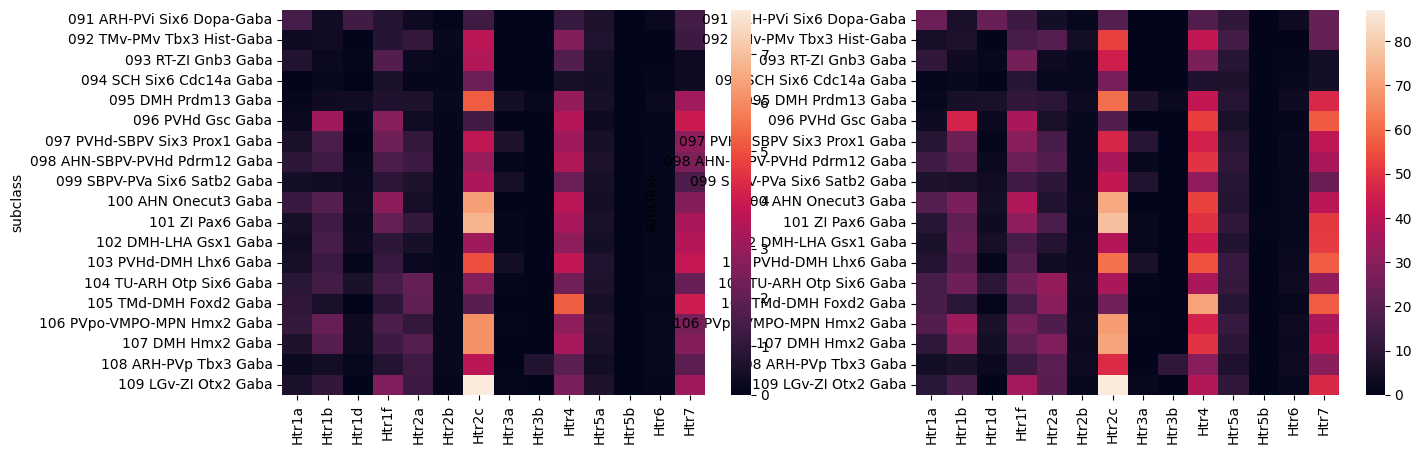

In [889]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
sns.heatmap(sub_joined.groupby("subclass")[htrgenes].mean(), yticklabels=True, ax=axs[0])
sns.heatmap(sub_joined_boolean.groupby("subclass")[htrgenes].sum().div(sub_joined_boolean.groupby("subclass").size(), axis="index") * 100,
            yticklabels=True, ax=axs[1])

<AxesSubplot:ylabel='subclass'>

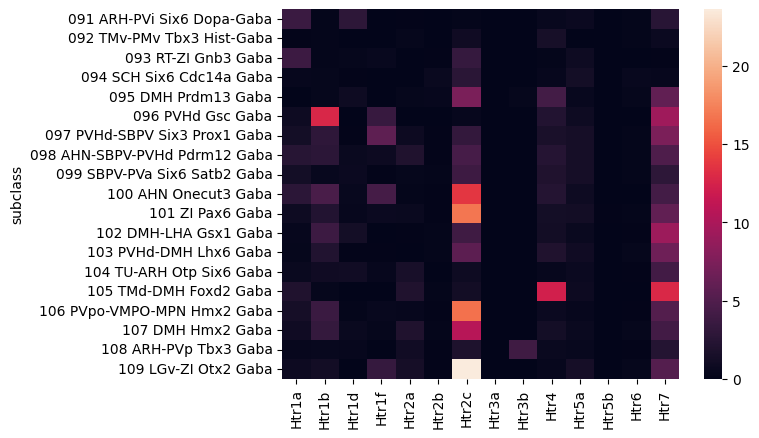

In [890]:
sns.heatmap(sub_joined_boolean_top_10.groupby("subclass")[htrgenes].sum().div(sub_joined_boolean_top_10.groupby("subclass").size(), axis="index") * 100,
            yticklabels=True)